# APIs: Exploring Guardian API Data
Guardian news data provides us a range of different types of variable that we can use to get an overall picture of our datatset, and perhaps even find a some interesting patterns along the way.

Below we look at a range of different options for examining Guardian Data. Whilst the text of the stories is obviously valuable data, we'll need more advanced text analysis methods for that. These methods allow us to get a good overall picture of our data and find general trends.

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [275]:
articles = pd.read_json('my_guardian_articles.json')
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2000 non-null   object
 1   type                2000 non-null   object
 2   sectionId           2000 non-null   object
 3   sectionName         2000 non-null   object
 4   webPublicationDate  2000 non-null   object
 5   webTitle            2000 non-null   object
 6   webUrl              2000 non-null   object
 7   apiUrl              2000 non-null   object
 8   fields              2000 non-null   object
 9   tags                2000 non-null   object
 10  isHosted            2000 non-null   bool  
 11  pillarId            1980 non-null   object
 12  pillarName          1980 non-null   object
dtypes: bool(1), object(12)
memory usage: 205.1+ KB


## Prepping the Data
First we get the data ready for analysis.

### Transforming the date column
First we need to ensure that our data is clean and that the `webPublicationDate` is properly formatted as a `datetime`.

In [276]:
articles.head()


,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,fields,tags,isHosted,pillarId,pillarName
0,technology/2023/oct/31/educators-teachers-ai-l...,article,technology,Technology,2023-10-31T10:00:39Z,‘Is this an appropriate use of AI or not?’: te...,https://www.theguardian.com/technology/2023/oc...,https://content.guardianapis.com/technology/20...,"{'byline': 'Johana Bhuiyan', 'body': '<p>In <a...","[{'id': 'technology/technology', 'type': 'keyw...",False,pillar/news,News
1,technology/ng-interactive/2023/oct/25/a-day-in...,interactive,technology,Technology,2023-10-25T13:38:11Z,A day in the life of AI,https://www.theguardian.com/technology/ng-inte...,https://content.guardianapis.com/technology/ng...,{'byline': 'Hannah Devlin Science Corresponden...,"[{'id': 'technology/artificialintelligenceai',...",False,pillar/news,News
2,technology/2023/oct/24/alphabet-q3-earnings-go...,article,technology,Technology,2023-10-24T22:07:37Z,Google Cloud revenue misses expectations despi...,https://www.theguardian.com/technology/2023/oc...,https://content.guardianapis.com/technology/20...,"{'byline': 'Kari Paul', 'body': '<p>Google is ...","[{'id': 'technology/alphabet', 'type': 'keywor...",False,pillar/news,News
3,stage/2023/sep/19/anthropology-review-hampstea...,article,stage,Stage,2023-09-19T12:02:55Z,Anthropology review – clever AI missing-person...,https://www.theguardian.com/stage/2023/sep/19/...,https://content.guardianapis.com/stage/2023/se...,"{'byline': 'Mark Lawson', 'body': '<p>While sc...","[{'id': 'stage/stage', 'type': 'keyword', 'sec...",False,pillar/arts,Arts
4,film/2023/aug/20/tim-review-clunky-ai-paranoia...,article,film,Film,2023-08-20T10:30:44Z,TIM review – clunky AI paranoia thriller,https://www.theguardian.com/film/2023/aug/20/t...,https://content.guardianapis.com/film/2023/aug...,"{'byline': 'Wendy Ide', 'body': '<p>This styli...","[{'id': 'film/thriller', 'type': 'keyword', 's...",False,pillar/arts,Arts


In [277]:
articles['webPublicationDate'] = pd.to_datetime(articles['webPublicationDate'])

### Unpacking the Fields column
The content of the `fields` column is determined when we collect our API data, by what we passed to `show-fields` in our query parameters. However what is returned is a dictionary of information. Ideally we want to expand these dictionaries out and create additional columns for each field (`byline`, `body` and `wordcount`).

We'll mainly be using `wordcount` but the process will unpack all fields.

In [278]:
articles.loc[0, 'fields']

{'byline': 'Johana Bhuiyan',
 'body': '<p>In <a href="https://www.theguardian.com/technology/2023/oct/12/chatgpt-uses-writing-recipes-one-year">the year since OpenAI released ChatGPT</a>, high school teacher Vicki Davis has been rethinking every single assignment she gives her students. Davis, a computer science teacher at Sherwood Christian Academy in Georgia, was well-positioned to be an early adopter of the technology. She’s also the IT director at the school and helped put together an AI policy in March: the school opted to allow the use of AI tools for specific projects so long as students discussed it with their teachers and cited the tool. In Davis’s mind, there were good and bad uses of AI, and ignoring its growing popularity was not going to help students unlock the productive uses or understand its dangers.</p> <aside class="element element-rich-link element--thumbnail"> <p> <span>Related: </span><a href="https://www.theguardian.com/technology/2023/oct/26/ai-artificial-intell

`.json_normalize` happens to do this kind of job for us, but it will create an entirely new dataframe from the results.

In [279]:
articles_field_data = pd.json_normalize(articles['fields'])
articles_field_data.head()

,byline,body,wordcount
0,Johana Bhuiyan,"<p>In <a href=""https://www.theguardian.com/tec...",1585
1,"Hannah Devlin Science Correspondent, Rich Cous...","<figure class=""element element-atom element--i...",1741
2,Kari Paul,"<p>Google is doing well, but not well enough f...",554
3,Mark Lawson,"<p>While screenwriters strike, partly over the...",410
4,Wendy Ide,<p>This stylishly icy-looking thriller sounds ...,86


Having produced our dataframe of field data we just need to merge the `articles` dataframe and the new one together, matching up the indexes.
When merging dataframes, left literally refers to the dataframe on the left of the operation, and right to the one most towards the right.

`left.merge(right)`


In [280]:
articles = articles.merge(articles_field_data, left_index=True, right_index=True)
articles.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  2000 non-null   object             
 1   type                2000 non-null   object             
 2   sectionId           2000 non-null   object             
 3   sectionName         2000 non-null   object             
 4   webPublicationDate  2000 non-null   datetime64[ns, UTC]
 5   webTitle            2000 non-null   object             
 6   webUrl              2000 non-null   object             
 7   apiUrl              2000 non-null   object             
 8   fields              2000 non-null   object             
 9   tags                2000 non-null   object             
 10  isHosted            2000 non-null   bool               
 11  pillarId            1980 non-null   object             
 12  pillarName          1980 non-null 

### Converting wordcount to numeric
Wordcount has been stored as a string. We can rectify that by using `.to_numeric`

In [281]:
articles['wordcount'] = pd.to_numeric(articles['wordcount'])

## Data Counts over time
A key question of a dataset about the news, would when this news took place. Equally, we may also be interested in trends over time. Depending on your query, it may be interesting to see if there were changing publication rates related to your topic of interest.

A simple `.describe` on the date column will tell us a little about the spread of the dates.

In [282]:
articles['webPublicationDate'].describe(datetime_is_numeric=True)

count                                   2000
mean     2023-03-31 20:56:41.787000064+00:00
min                2020-08-21 14:20:31+00:00
25%      2023-01-31 11:58:43.750000128+00:00
50%                2023-05-25 13:13:57+00:00
75%      2023-08-15 11:19:21.750000128+00:00
max                2023-11-08 15:05:42+00:00
Name: webPublicationDate, dtype: object

If we want to see trends, we can group our rows by publication period such as by `D`ay, `M`onth or `Y`ear. To do this we make a special time grouping object, and then group our data using it. We count the number of articles in each group and then plot them as a line plot.

In [290]:
time_grouper = pd.Grouper(key='webPublicationDate', freq='M')
count_over_time = articles[['webPublicationDate','id']].groupby(time_grouper).count().reset_index()
count_over_time.head()

,webPublicationDate,id
0,2020-08-31 00:00:00+00:00,1
1,2020-09-30 00:00:00+00:00,0
2,2020-10-31 00:00:00+00:00,0
3,2020-11-30 00:00:00+00:00,2
4,2020-12-31 00:00:00+00:00,7


Time series are a little trickier to plot and Seaborn doesn't have a built in covnenience method for it. However we can use the `sns.lineplot` method to manually create one, and make some adjustments to size and label positioning manually.

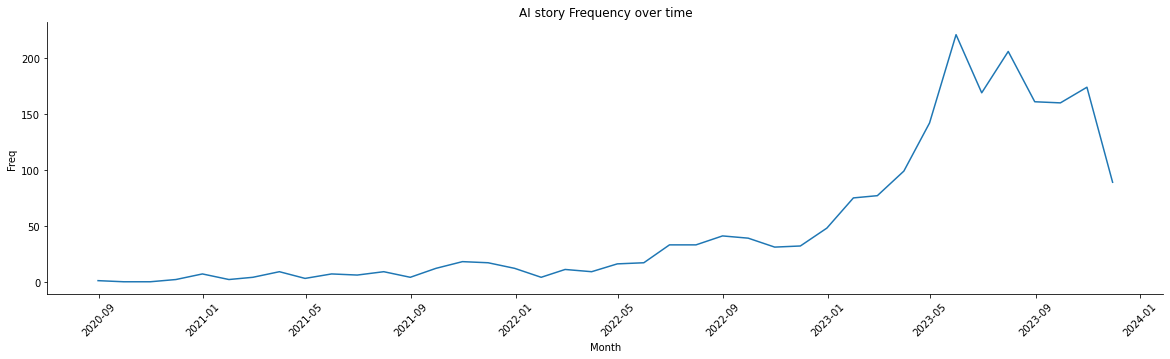

In [298]:
plt.figure(figsize=(20,5))
plot = sns.lineplot(data=count_over_time, x='webPublicationDate', y='id')

plot.tick_params(axis='x', labelrotation=45)
plot.set(title='AI story Frequency over time', xlabel='Month', ylabel='Freq')
sns.despine()
plt.show()

## Optional: Filtering by a Date Range
Using our timeseries plot we might decide to filter our data so we only work with a specific range period.

In [299]:
date_filter = articles['webPublicationDate'] >= 'January 2022'
articles = articles[date_filter]

In [300]:
articles['webPublicationDate'].describe()

<ipython-input-300-a6523f342fc1>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  articles['webPublicationDate'].describe()


count                          1887
unique                         1863
top       2023-03-26 09:00:14+00:00
freq                              3
first     2022-01-09 09:00:17+00:00
last      2023-11-08 15:05:42+00:00
Name: webPublicationDate, dtype: object

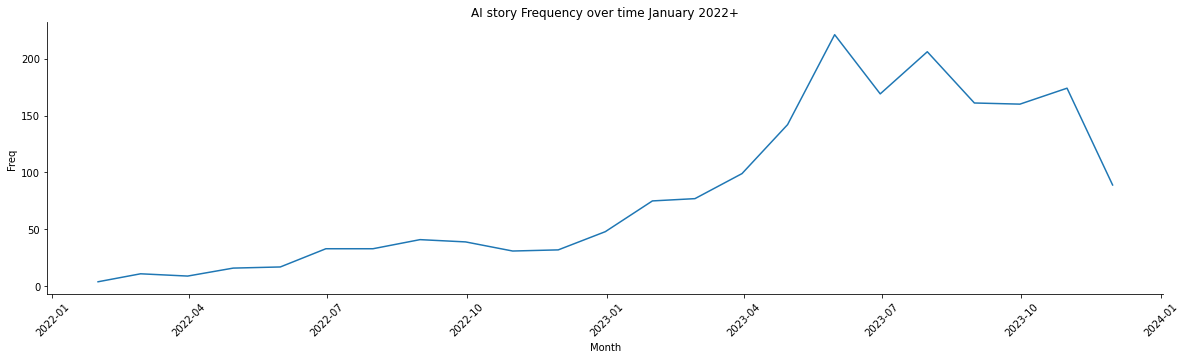

In [302]:
time_grouper = pd.Grouper(key='webPublicationDate', freq='M')
count_over_time = articles[['webPublicationDate','id']].groupby(time_grouper).count().reset_index()

plt.figure(figsize=(20,5))
plot = sns.lineplot(data=count_over_time, x='webPublicationDate', y='id')
plot.tick_params(axis='x', labelrotation=45)
plot.set(title='AI story Frequency over time January 2022+', xlabel='Month', ylabel='Freq')
sns.despine()
plt.show()

## Appropriate Pillars?
The Guardian has a number of major sections they refer to as Pillars. We can examine the distribution of our articles across these major categories.

In [305]:
pillar_counts = articles['pillarName'].value_counts()
pillar_counts


News         1072
Arts          479
Opinion       201
Lifestyle      73
Sport          42
Name: pillarName, dtype: int64

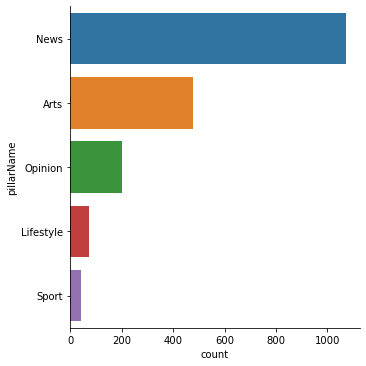

In [306]:
sns.catplot(data=articles, y='pillarName', kind='count', order=pillar_counts.index)

## Optional: Filtering by Pillar
Depending on your search query and the type of question you have, it may be worth filtering out material in unsuitable pillars, or focusing on just one.

In [307]:
chosen_pillars = ['News', 'Opinion']
pillar_filter = articles['pillarName'].isin(chosen_pillars)
articles = articles[pillar_filter]

After filtering we can re-run our counts to check the filtering was applied, and produce a new visualisation of we need it.

In [308]:
new_pillar_counts = articles['pillarName'].value_counts()
new_pillar_counts

News       1072
Opinion     201
Name: pillarName, dtype: int64

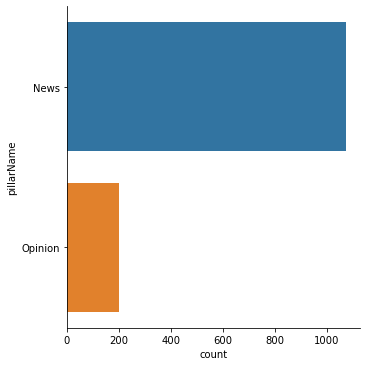

In [309]:
sns.catplot(data=articles, y='pillarName', kind='count', order=new_pillar_counts.index)

## Sections
Sections are the next form of categorisation. Sections give us a better sense of the overall topic of the stories.

In [310]:
section_counts = articles['sectionName'].value_counts()
section_counts

Technology            437
Opinion               201
Australia news        111
Business               95
World news             93
Politics               69
US news                66
Science                37
Environment            33
News                   31
Society                30
UK news                21
Media                  20
Global development     12
Education               5
From the Observer       5
Info                    4
Law                     2
Help                    1
Name: sectionName, dtype: int64

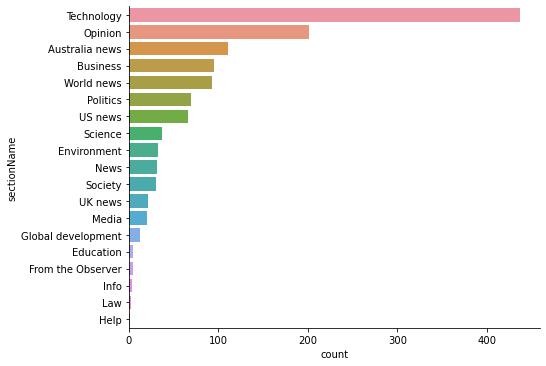

In [311]:

sns.catplot(data=articles, y='sectionName', kind='count', aspect=1.5, order=section_counts.index)


Depending on how many sections are involved we may decide to keep only those above a certain threshold of presence in our dataset. This could be a top 10 or 20, or you could base it on some sort of summary metric of the counts such as categories above the mean or median count.

In [315]:
section_counts.describe()


count     19.000000
mean      67.000000
std      102.893148
min        1.000000
25%        8.500000
50%       31.000000
75%       81.000000
max      437.000000
Name: sectionName, dtype: float64

In [318]:
above_avg_sections = section_counts[section_counts > section_counts.median()].index
above_avg_sections

Index(['Technology', 'Opinion', 'Australia news', 'Business', 'World news',
       'Politics', 'US news', 'Science', 'Environment'],
      dtype='object')

We'll just go with a top 10

In [319]:
top_sections = section_counts.index[:10]
top_sections

Index(['Technology', 'Opinion', 'Australia news', 'Business', 'World news',
       'Politics', 'US news', 'Science', 'Environment', 'News'],
      dtype='object')

In [320]:
articles = articles[articles['sectionName'].isin(top_sections)]
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1173 entries, 0 to 1997
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  1173 non-null   object             
 1   type                1173 non-null   object             
 2   sectionId           1173 non-null   object             
 3   sectionName         1173 non-null   object             
 4   webPublicationDate  1173 non-null   datetime64[ns, UTC]
 5   webTitle            1173 non-null   object             
 6   webUrl              1173 non-null   object             
 7   apiUrl              1173 non-null   object             
 8   fields              1173 non-null   object             
 9   tags                1173 non-null   object             
 10  isHosted            1173 non-null   bool               
 11  pillarId            1173 non-null   object             
 12  pillarName          1173 non-null 

## Tags
Tags are the last categorisation and they give us even more nuance in exactly what each story is about. However they are a little trickier to deal with because each story can have more than one tag associated with it. This presents us more of a challenge but also an opportunity for analysis too.

In [163]:
articles['tags'].iloc[1]

[{'id': 'technology/artificialintelligenceai',
  'type': 'keyword',
  'sectionId': 'technology',
  'sectionName': 'Technology',
  'webTitle': 'Artificial intelligence (AI)',
  'webUrl': 'https://www.theguardian.com/technology/artificialintelligenceai',
  'apiUrl': 'https://content.guardianapis.com/technology/artificialintelligenceai',
  'references': []},
 {'id': 'technology/computing',
  'type': 'keyword',
  'sectionId': 'technology',
  'sectionName': 'Technology',
  'webTitle': 'Computing',
  'webUrl': 'https://www.theguardian.com/technology/computing',
  'apiUrl': 'https://content.guardianapis.com/technology/computing',
  'references': []},
 {'id': 'technology/technology',
  'type': 'keyword',
  'sectionId': 'technology',
  'sectionName': 'Technology',
  'webTitle': 'Technology',
  'webUrl': 'https://www.theguardian.com/technology/technology',
  'apiUrl': 'https://content.guardianapis.com/technology/technology',
  'references': []},
 {'id': 'uk/uk',
  'type': 'keyword',
  'sectionId

In [164]:
len(articles)

1273

In [165]:
tag_per_line = articles.explode('tags')
len(tag_per_line)

8407

In [170]:
tag_data = pd.json_normalize(tag_per_line['tags'])
tag_data['story_index'] = tag_per_line.index
tag_data['wordcount'] = tag_per_line['wordcount'].tolist()
tag_data

,id,type,sectionId,sectionName,webTitle,webUrl,apiUrl,references,description,activeSponsorships,story_index,wordcount
0,technology/technology,keyword,technology,Technology,Technology,https://www.theguardian.com/technology/technology,https://content.guardianapis.com/technology/te...,[],NaN,NaN,0,1585
1,technology/artificialintelligenceai,keyword,technology,Technology,Artificial intelligence (AI),https://www.theguardian.com/technology/artific...,https://content.guardianapis.com/technology/ar...,[],NaN,NaN,0,1585
2,education/education,keyword,education,Education,Education,https://www.theguardian.com/education/education,https://content.guardianapis.com/education/edu...,[],NaN,NaN,0,1585
3,technology/artificialintelligenceai,keyword,technology,Technology,Artificial intelligence (AI),https://www.theguardian.com/technology/artific...,https://content.guardianapis.com/technology/ar...,[],NaN,NaN,1,1741
4,technology/computing,keyword,technology,Technology,Computing,https://www.theguardian.com/technology/computing,https://content.guardianapis.com/technology/co...,[],NaN,NaN,1,1741
...,...,...,...,...,...,...,...,...,...,...,...,...
8402,politics/politics,keyword,politics,Politics,Politics,https://www.theguardian.com/politics/politics,https://content.guardianapis.com/politics/poli...,[],<p><br></p>,NaN,1997,2720
8403,business/business,keyword,business,Business,Business,https://www.theguardian.com/business/business,https://content.guardianapis.com/business/busi...,[],NaN,NaN,1997,2720
8404,uk/uk,keyword,uk-news,UK news,UK news,https://www.theguardian.com/uk/uk,https://content.guardianapis.com/uk/uk,[],NaN,NaN,1997,2720
8405,business/financial-conduct-authority,keyword,business,Business,Financial Conduct Authority,https://www.theguardian.com/business/financial...,https://content.guardianapis.com/business/fina...,[],The latest news and comment on the Financial C...,NaN,1997,2720


In [171]:
tag_counts = tag_data['webTitle'].value_counts().head(20)
top_tags = tag_counts.index
tag_counts

Technology                      672
Artificial intelligence (AI)    593
Computing                       377
UK news                         353
World news                      229
Business                        220
US news                         218
Politics                        179
Australia news                  154
ChatGPT                         150
Science                         136
Consciousness                   106
Rishi Sunak                     102
Media                            93
Google                           92
Internet                         70
Environment                      67
Chatbots                         65
Society                          60
Conservatives                    58
Name: webTitle, dtype: int64

## Word Counts

### By Section

In [182]:
articles.groupby('sectionName').agg(
    avg_wordcount=('wordcount','mean'),
    total_wordcount=('wordcount','sum')
).sort_values('total_wordcount', ascending=False).loc[top_sections]

,avg_wordcount,total_wordcount
Technology,854.544622,373436
Opinion,905.955224,182097
Australia news,2039.099099,226340
Business,1412.684211,134205
World news,1616.053763,150293
Politics,2216.072464,152909
US news,1786.863636,117933
Science,917.540541,33949
Environment,874.878788,28871
News,267.451613,8291


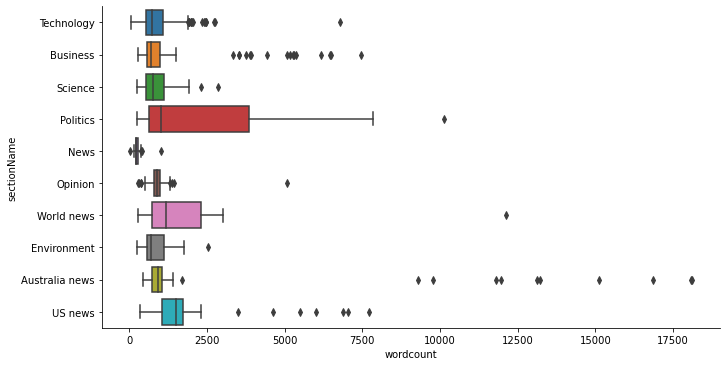

In [235]:
to_plot = articles[articles['sectionName'].isin(top_sections)]
sns.catplot(data=to_plot, y='sectionName', x='wordcount', kind='box', aspect=2)

### By Tag

In [215]:
tag_data.groupby('webTitle').agg(
    avg_wordcount=('wordcount','mean'),
    total_wordcount=('wordcount','sum')
).sort_values('total_wordcount', ascending=False).loc[top_tags]

,avg_wordcount,total_wordcount
Technology,911.842262,612758
Artificial intelligence (AI),963.428331,571313
Computing,947.620690,357253
UK news,1115.385269,393731
World news,1000.685590,229157
Business,1249.795455,274955
US news,1273.756881,277679
Politics,1452.217877,259947
Australia news,1734.136364,267057
ChatGPT,849.960000,127494


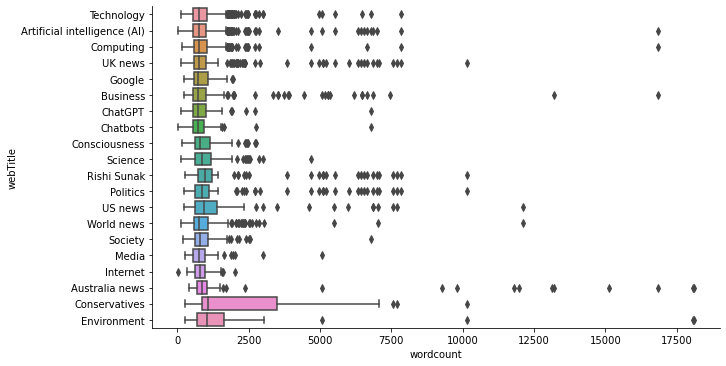

In [223]:
to_plot = tag_data[tag_data['webTitle'].isin(top_tags)]
sns.catplot(data=to_plot, y='webTitle', x='wordcount', kind='box', aspect=2)

## Tag Correlation

In [258]:
M = pd.get_dummies(tag_data['webTitle'])
M = M[top_tags]
M['story_index'] = tag_per_line.index
M

,Technology,Artificial intelligence (AI),Computing,UK news,World news,Business,US news,Politics,Australia news,ChatGPT,...,Consciousness,Rishi Sunak,Media,Google,Internet,Environment,Chatbots,Society,Conservatives,story_index
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1997
8403,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
8404,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
8405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1997


In [259]:
M = M.groupby('story_index').sum()
M


,Technology,Artificial intelligence (AI),Computing,UK news,World news,Business,US news,Politics,Australia news,ChatGPT,Science,Consciousness,Rishi Sunak,Media,Google,Internet,Environment,Chatbots,Society,Conservatives
story_index,,,,,,,,,,,,,,,,,,,,
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1992,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [262]:
correlations = M.corr()
correlations

,Technology,Artificial intelligence (AI),Computing,UK news,World news,Business,US news,Politics,Australia news,ChatGPT,Science,Consciousness,Rishi Sunak,Media,Google,Internet,Environment,Chatbots,Society,Conservatives
Technology,1.000000,0.570840,0.530719,-0.008239,0.086498,0.024275,0.012199,-0.101811,-0.242690,0.267538,0.157677,0.250845,-0.057058,0.090136,0.203180,0.159095,-0.150580,0.176478,0.009851,-0.185758
Artificial intelligence (AI),0.570840,1.000000,0.601485,0.023085,0.042333,-0.088987,-0.044103,0.011854,-0.143608,0.337637,0.170138,0.322734,0.055021,0.004102,0.171163,0.002708,-0.114323,0.212629,0.022666,-0.075653
Computing,0.530719,0.601485,1.000000,0.020981,0.094884,-0.045952,-0.075637,0.004895,-0.166769,0.291260,0.208411,0.414803,0.024036,-0.043255,0.164487,0.039773,-0.098953,0.201277,-0.006244,-0.100469
UK news,-0.008239,0.023085,0.020981,1.000000,-0.002290,0.083059,-0.081285,0.511675,-0.213651,-0.073991,0.018523,-0.002500,0.353655,-0.066007,-0.057680,0.004535,-0.075276,-0.048025,0.094081,0.260159
World news,0.086498,0.042333,0.094884,-0.002290,1.000000,0.007662,0.145406,-0.036479,-0.136115,0.038165,0.056049,0.036506,-0.002627,0.009983,0.019352,0.003658,0.026995,0.030727,0.030946,-0.082713
Business,0.024275,-0.088987,-0.045952,0.083059,0.007662,1.000000,0.078573,-0.041222,-0.067258,-0.018734,-0.136039,-0.099612,-0.035222,0.055010,0.104544,0.062569,-0.042372,-0.011577,-0.062102,-0.079505
US news,0.012199,-0.044103,-0.075637,-0.081285,0.145406,0.078573,1.000000,-0.087899,-0.155846,0.014957,-0.082286,-0.061528,-0.026632,0.024630,0.042238,-0.018180,-0.069791,-0.020189,-0.081420,-0.059321
Politics,-0.101811,0.011854,0.004895,0.511675,-0.036479,-0.041222,-0.087899,1.000000,-0.150059,-0.105780,-0.022663,-0.015581,0.588130,-0.061455,-0.095444,-0.077748,-0.034621,-0.073298,0.016669,0.507632
Australia news,-0.242690,-0.143608,-0.166769,-0.213651,-0.136115,-0.067258,-0.155846,-0.150059,1.000000,-0.060865,-0.111789,-0.111805,-0.109488,-0.067119,-0.057025,-0.047217,0.020440,-0.086053,-0.082507,-0.081053
ChatGPT,0.267538,0.337637,0.291260,-0.073991,0.038165,-0.018734,0.014957,-0.105780,-0.060865,1.000000,0.085861,0.224963,-0.098890,-0.018336,0.189694,0.040100,-0.064320,0.324771,-0.012301,-0.079851


In [263]:
correlations.loc['ChatGPT'].sort_values(ascending=False)

ChatGPT                         1.000000
Artificial intelligence (AI)    0.337637
Chatbots                        0.324771
Computing                       0.291260
Technology                      0.267538
Consciousness                   0.224963
Google                          0.189694
Science                         0.085861
Internet                        0.040100
World news                      0.038165
US news                         0.014957
Society                        -0.012301
Media                          -0.018336
Business                       -0.018734
Australia news                 -0.060865
Environment                    -0.064320
UK news                        -0.073991
Conservatives                  -0.079851
Rishi Sunak                    -0.098890
Politics                       -0.105780
Name: ChatGPT, dtype: float64

### Tag Heatmap

<AxesSubplot:>

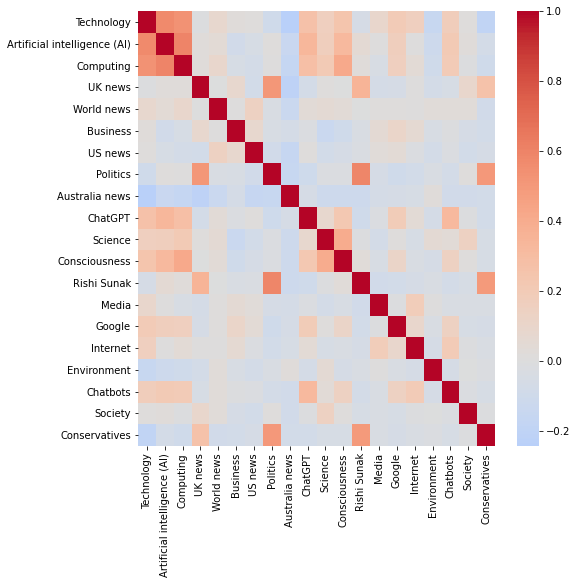

In [274]:
plt.figure(figsize=(8,8))

sns.heatmap(correlations, cmap='coolwarm', center=0)